# Part 1

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy.linalg as la
import typing
from typing import List, Tuple


Experimental Constants

In [3]:
BOLT_NUM = 17
FRAME_RATE = 240

Loading vibration Data

In [4]:
data_dict = dict(np.load(r'data\\AutonomousTrajectoriesBig.npz'))
data_all = [it[1] for it in data_dict.items()]

In [5]:
data_dict.keys()

dict_keys(['T10', 'T11', 'T13', 'T20', 'T4', 'T18', 'T3', 'T14', 'T5', 'T17', 'T9', 'T23', 'T24', 'T21', 'T7', 'T6', 'T22', 'T12', 'T19', 'T15', 'T1', 'T2', 'T8', 'T16'])

In [6]:
print(len(data_all))
data_all[0].shape

24


(17, 7453)

# 1.1
 Reversing columns of the data matrices, so that data is in increasing time

In [7]:
ordered_data_all = []
for data_mat in data_all:
    ordered_data_all.append(data_mat[:, ::-1])

# ensuring that the data is reversed correctly
for mat_reverse, mat_forward in zip(data_all, ordered_data_all):
    assert np.allclose(mat_reverse[:, ::-1], mat_forward)


In [8]:
print(ordered_data_all[0][0, :])
print(data_all[0][0, :])
ordered_data_all[0].shape


[ 0.04094743  0.02806029  0.00584782 ...  0.0129485  -0.00066601
  0.00832467]
[ 0.00832467 -0.00066601  0.0129485  ...  0.00584782  0.02806029
  0.04094743]


(17, 7453)

At this point it's probably a good idea to visualise the data to get a clearer picture of the signal and any steady states

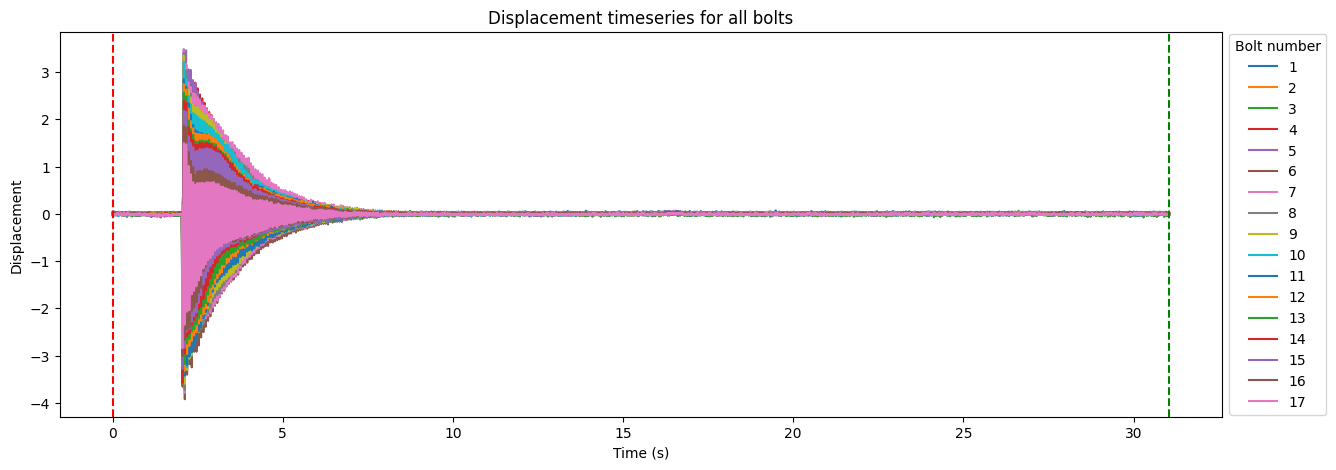

In [9]:
def get_time_from_frames(frames):
    t_final = frames / FRAME_RATE
    t = np.linspace(0, t_final, frames)
    return t

def plot_timeseries(data, start=0, stop=-1, fig_size=(15, 5), show_legend=True):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    
    if stop == -1:
        stop = data.shape[1]

    # time of each measurement is determined based on the camera frame rate and the number of columns in the data array
    frame_count = data.shape[1]
    t = get_time_from_frames(frame_count)
    
    # t = t[start:stop+1]
    # plotting the timeseries data for each bolt
    for i in range(BOLT_NUM):
        ax.plot(t, data[i, :], label=f'{i+1}')
    
    ax.axvline(x=t[start], color='r', linestyle='--')
    ax.axvline(x=t[stop-1], color='g', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement')

    if show_legend:
        ax.legend(title='Bolt number', loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title('Displacement timeseries for all bolts')
    plt.show()

plot_timeseries(ordered_data_all[0], start=0, stop=-1)



# 1.3
Now let's ensure that each trajectory has zero mean (oscillation about 0 displacement). pesonally I feel it makes more sense to do this before clipping the trajectories

In [10]:
def zero_mean(data):
    return data - np.mean(data, axis=1, keepdims=True)

ordered_data_all = [zero_mean(data) for data in ordered_data_all]

# validating that zeroing the mean has worked
for data in ordered_data_all:
    assert np.allclose(np.mean(data, axis=1), 0, rtol=1e-15), 'Mean is not zeroed to machine precision'

# 1.2 
We can clearly see the initial steady state and the long time steady state from the above plot. We can remove these from the data matrix whilst keeping the no. of columns consistent for each test by calculating the absolute mean and std of the displacement at each timestep accross all bolts 

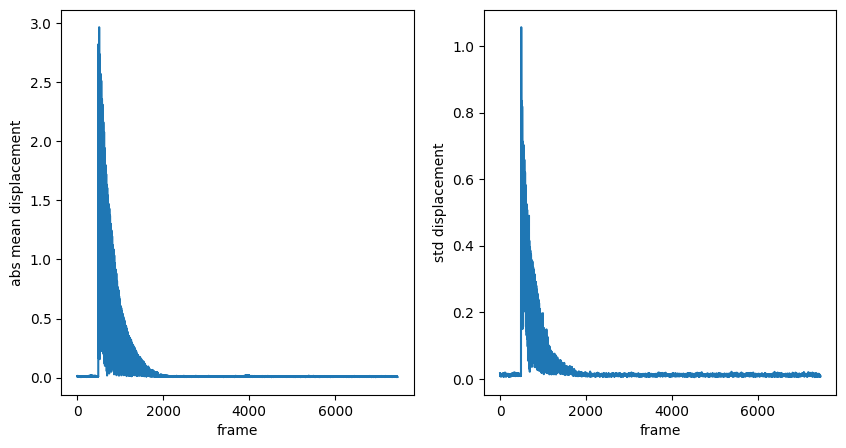

In [11]:
mean_series = np.mean(np.abs(ordered_data_all[0]), axis=0)
std_series = np.std(ordered_data_all[0], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(mean_series)
axs[1].plot(std_series)
axs[0].set_xlabel('frame')
axs[0].set_ylabel('abs mean displacement')
axs[1].set_xlabel('frame')
axs[1].set_ylabel('std displacement')
plt.show()

So we can remove the steady state time by selecting points that exceed some minimum absolute mean and standard deviation. The problem is that some of the data matrices are noisier than others. A hacky way around this is that if we look at all of the data, every single experiment is definitely at a steady state after 20 seconds, so we can simply calculate the mean and std of the steady state for each matrix and use this as the threshold

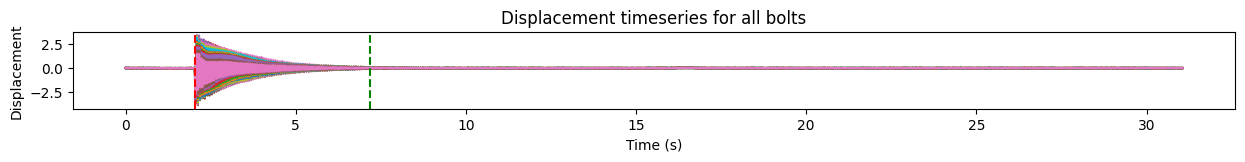

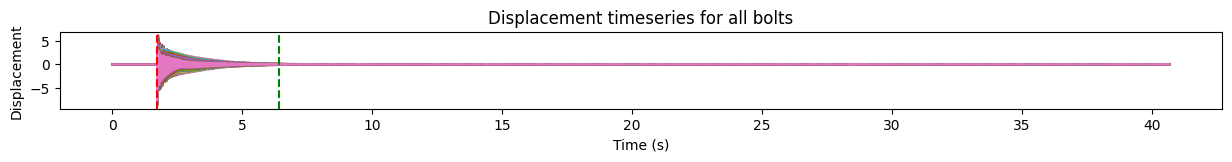

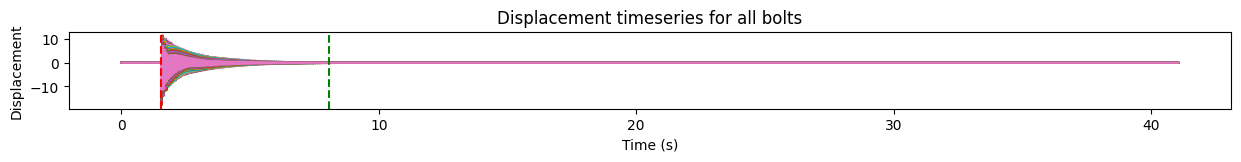

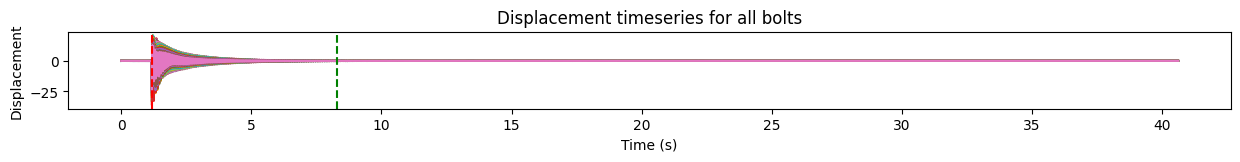

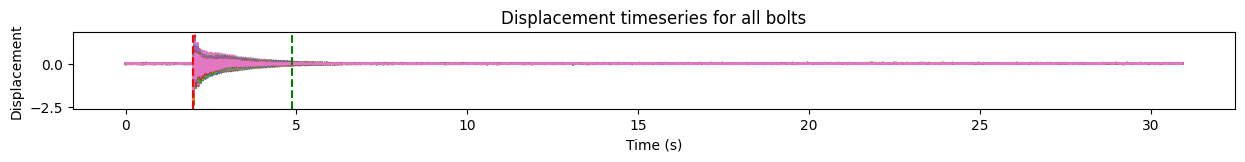

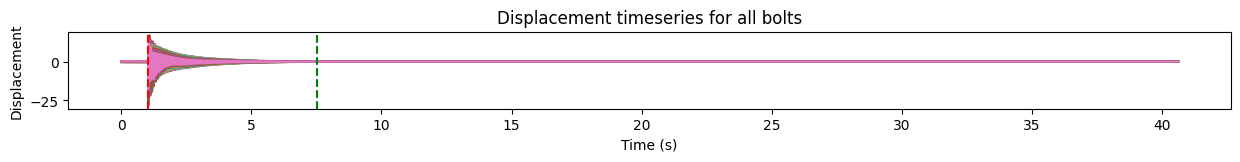

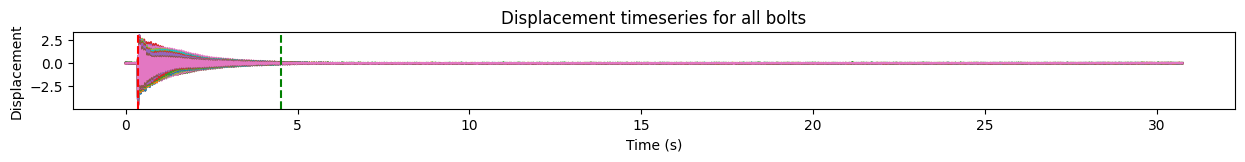

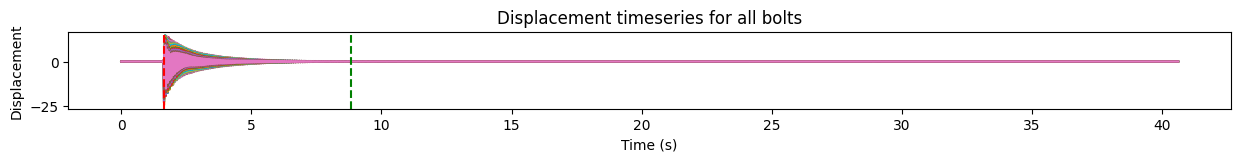

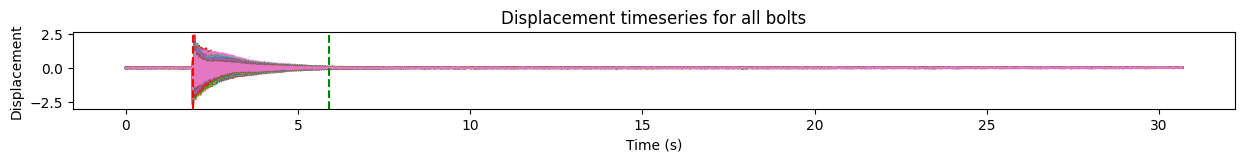

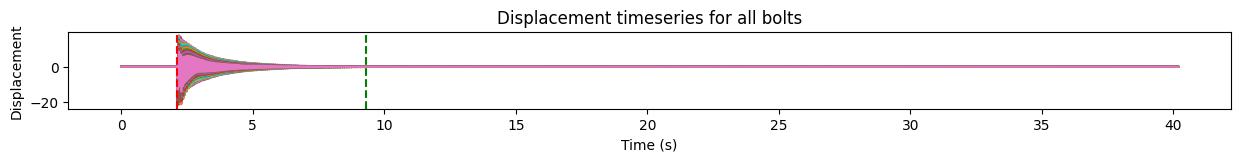

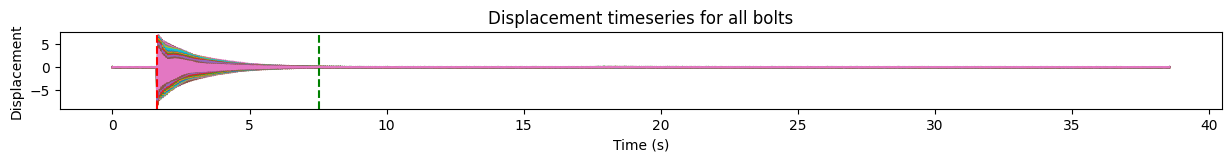

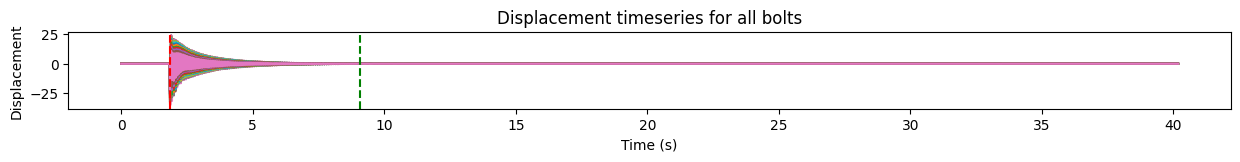

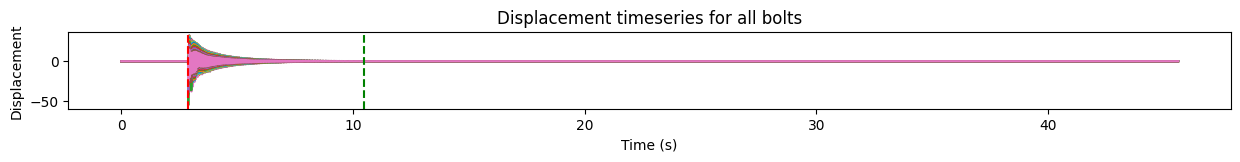

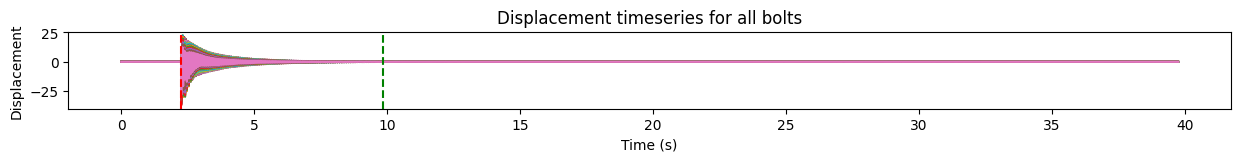

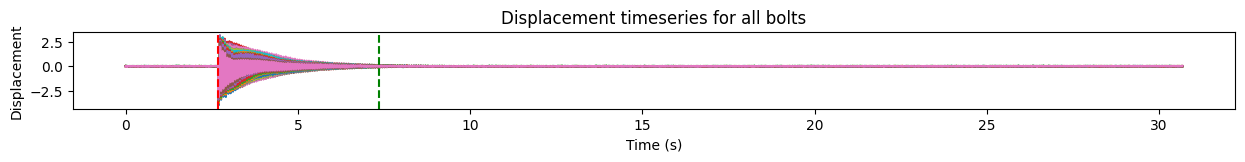

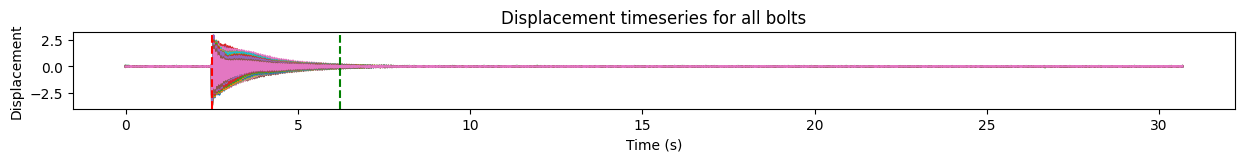

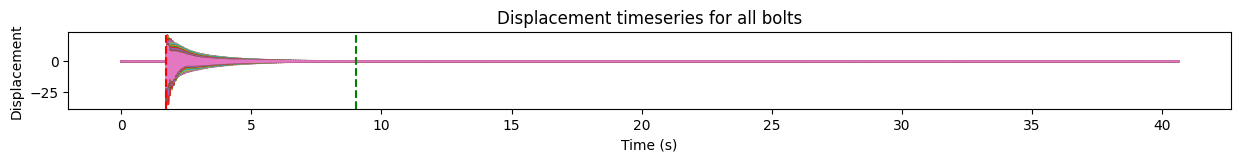

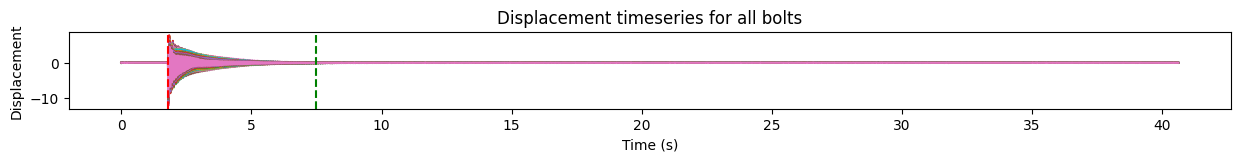

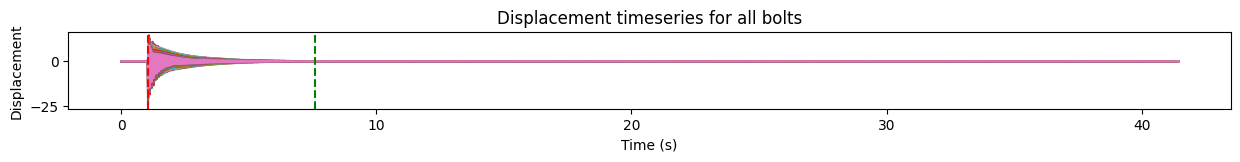

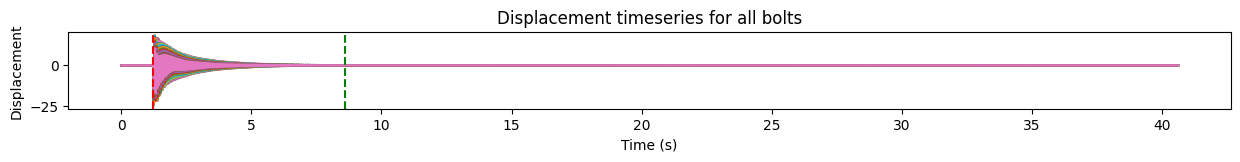

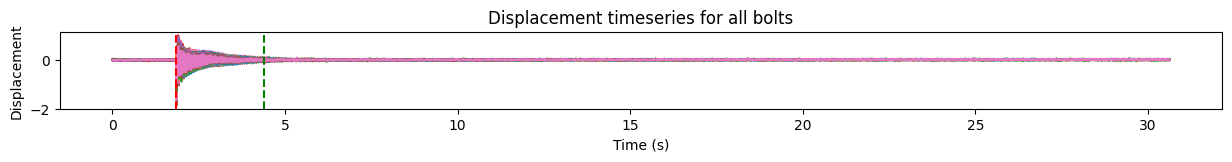

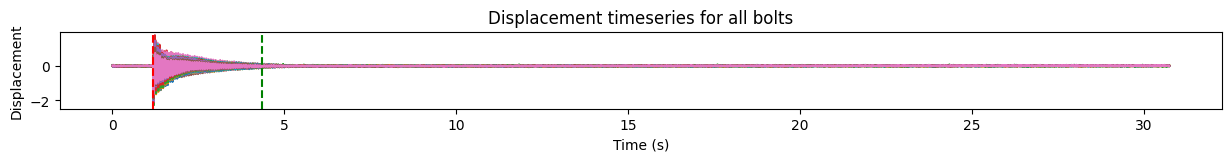

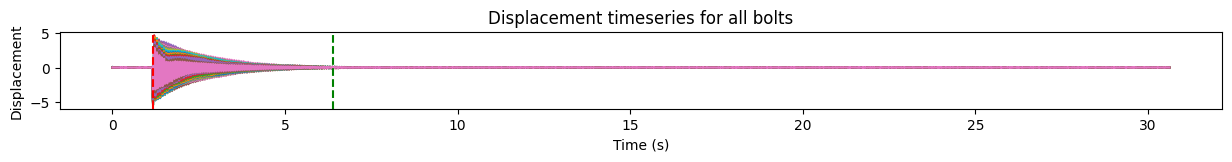

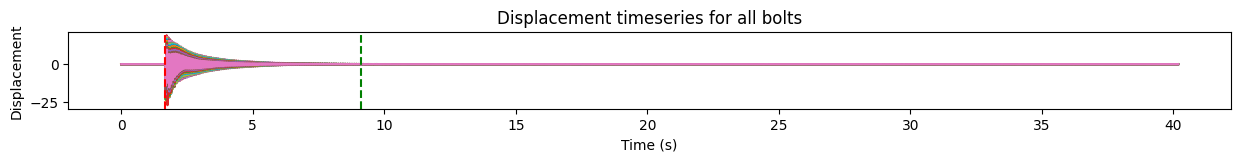

In [12]:
def find_steady_state(data):
    # timeseries of mean and std displacement across all bolts
    mean_series = np.mean(abs(data), axis=0)
    std_series = np.std(data, axis=0)
    
    # getting the maximum mean and std values accross each bolt after t=20s
    t = get_time_from_frames(data.shape[1])
    steady_start = np.where(t > 20)[0][0]
    mean_threshold = 1.4 * np.max(mean_series[steady_start:]) # fudge factor of 1.4 determined empirically
    std_threshold = 1.4 *np.max(std_series[steady_start:])
    
    # getting indices of the transient state using mean and std thresholds
    transient_mean = np.where(mean_series > mean_threshold)
    transient_std = np.where(std_series > std_threshold)
    transient_indices = np.intersect1d(transient_mean, transient_std)
    # stop at the last transient index
    stop = transient_indices[-1]
    # start index can be calculated in a more straightforward way
    max_mean = np.max(mean_series)
    start = np.where(mean_series > 0.05*max_mean)[0][0]

    return start, stop

# visually validating the start and stop positions
for i, data in enumerate(ordered_data_all):
    start, stop = find_steady_state(data)
    plot_timeseries(data, start=start, stop=stop, fig_size=(15, 1), show_legend=False)
    # trimming the data
    ordered_data_all[i] = data[:, start:stop]





### 1.4
We do not know that the damping in the system is linear, therefore we cannot be certain that it is independent of the magnitude of displacement, so the rescaling should take place accross all matrices aggregated instead of individually. scaling values between 1 and -1 can be benificial for numerical stability. EXPAND ON THIS

In [13]:
print("shape pre scaling", ordered_data_all[0].shape)

scale = -1
for data in ordered_data_all:
    abs_max = np.max(np.abs(data))
    if abs_max > scale:
        scale = abs_max

print("max absolute displacement in dataset =", scale)

for i, data in enumerate(ordered_data_all):
    ordered_data_all[i] = data / scale



# validating that the data has been scaled correctly
for i, data in enumerate(ordered_data_all):
    max_displacement = np.max(np.abs(data))
    assert (max_displacement <= 1), 'Data is not scaled correctly'
    print("test {}, max displacement = {}".format(i, max_displacement))

print("shape post scaling", ordered_data_all[0].shape)

shape pre scaling (17, 1233)
max absolute displacement in dataset = 55.48334941356079
test 0, max displacement = 0.07059311811776454
test 1, max displacement = 0.1565874918485385
test 2, max displacement = 0.32333699954442024
test 3, max displacement = 0.6549470583990947
test 4, max displacement = 0.043345357739661076
test 5, max displacement = 0.5064418694761994
test 6, max displacement = 0.08161618402387845
test 7, max displacement = 0.44364204842689825
test 8, max displacement = 0.04917663160833219
test 9, max displacement = 0.39186958405823463
test 10, max displacement = 0.14827725615501441
test 11, max displacement = 0.6313230266914259
test 12, max displacement = 1.0
test 13, max displacement = 0.6654106550698466
test 14, max displacement = 0.07171305914919684
test 15, max displacement = 0.06582859031778138
test 16, max displacement = 0.653678759477482
test 17, max displacement = 0.21717157286833597
test 18, max displacement = 0.44566712647365087
test 19, max displacement = 0.4401

### plotting the final dataset as a sanity check


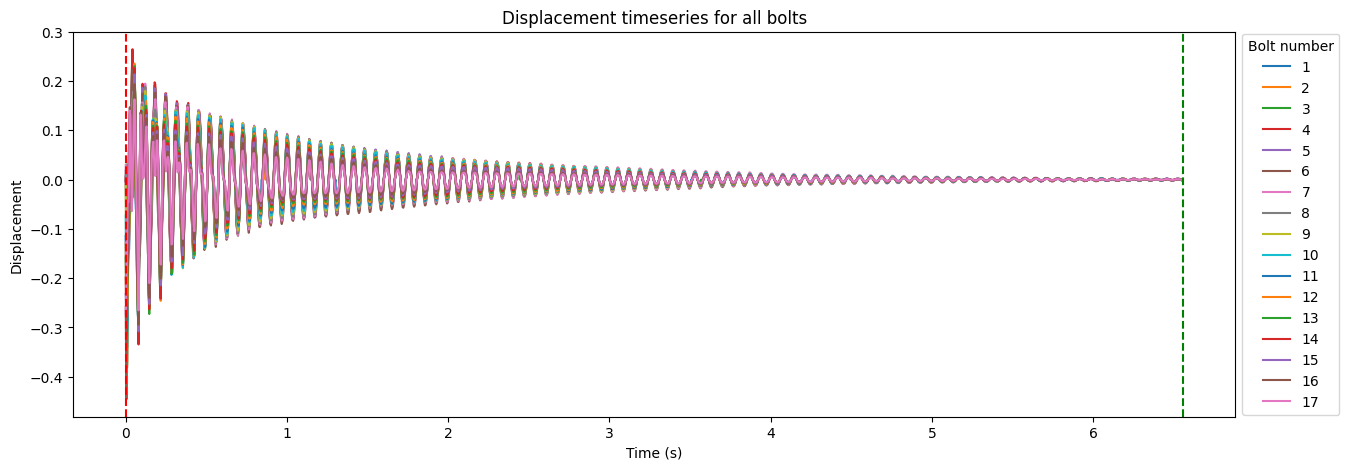

In [14]:
plot_timeseries(ordered_data_all[random.randint(0, len(ordered_data_all)-1)], start=0, stop=-1)

# 1.5
Optional. Skipping for now

# 2.1

It is necissary to seperate the data into a training and testing set to ensure that our model is not overfit to the training data. If it performs well on the training data, but poorly on the test data, the model is likely overfit.

Since we don't have a lot of data, we'll do a 60-40 train-test split.

In [15]:
shuffled_data = random.sample(ordered_data_all, len(ordered_data_all))
train_data = shuffled_data[:int(len(shuffled_data)*0.6)]
test_data = shuffled_data[int(len(shuffled_data)*0.6):]

print(len(train_data), len(test_data))

14 10


# 2.2

We are using delay embedding to determine the states and linear model which generate the observed data. Assuming that the system is observable

Given each data matrix consists of $y_1, y_2, \cdots, y_n$, where $y_i$ is a vector containing the displacement of each of the 17 bolts at frame, I can form a Hankel matrix by choosing some arbitrary dimensionality, and then ensure that it is large enough to capture the unobserved state space afterwards.

In [ ]:
# function to generate hankel matrix of delay embeddings
def hankel_matrix(data: np.array, delay: int):
    """
    args:
    ------
    data: np.array, timeseries of shape (n,m) where m is the number of timesteps and n is the number of features
    delay: int, delay window size

    returns:
    --------
    hankel: np.array, hankel matrix of shape (delay*n, m-delay+1)
    """
    n = data.shape[0]
    m = data.shape[1]
    
    hankel = np.zeros((delay*n, m-delay+1))
    for i in range(delay):
        hankel[i*n:(i+1)*n, :] = data[:, i:m-delay+(i+1)] 
    return hankel

print("original shape")
print(ordered_data_all[0].shape)

test_hankel = hankel_matrix(ordered_data_all[0], 5)
print("hankel shape")
print(test_hankel.shape)
print("first 4 columns of hankel (first variable)")
print(test_hankel[::17, :4])
print("last 4 columns of hankel")
print(test_hankel[::17, -4:])

original shape
(17, 1233)
hankel shape
(85, 1229)
first 6 columns of hankel
[[-0.00063655 -0.00574444 -0.01780522 -0.03044872]
 [-0.00574444 -0.01780522 -0.03044872 -0.03750394]
 [-0.01780522 -0.03044872 -0.03750394 -0.0469262 ]
 [-0.03044872 -0.03750394 -0.0469262  -0.04294431]
 [-0.03750394 -0.0469262  -0.04294431 -0.02676287]]
last 4 columns of hankel
[[-4.91001232e-04 -2.72645871e-04 -4.64969538e-04 -7.34622306e-05]
 [-2.72645871e-04 -4.64969538e-04 -7.34622306e-05 -3.57868805e-05]
 [-4.64969538e-04 -7.34622306e-05 -3.57868805e-05  5.09670726e-04]
 [-7.34622306e-05 -3.57868805e-05  5.09670726e-04  7.18850264e-04]
 [-3.57868805e-05  5.09670726e-04  7.18850264e-04  8.44873989e-04]]


In [142]:
def decorrelate(data: np.array, kappa: float = 1e6, verbose: bool = True):
    """
    data: np.array, data matrix to decorrelate, row wise
    """
    # performing SVD on the correlation matrix
    cor_mat = data @ data.T
    U, s_vec, _ = np.linalg.svd(cor_mat, full_matrices=False, hermitian=True) # economy svd and correlation matrix is symmetric
    # selecting columns of u that satisfy stability condition
    significant_cols = np.where(s_vec[0] / s_vec < kappa)[0]
    U = U[:, significant_cols]
    decorrelated = U.T @ data

    if verbose:
        print("Decorrelating data: \n")
        print(" U, S shape: ", U.shape, s_vec.shape, "\n")
        print(" singular values: ", s_vec, "\n")
        print(" U shape after filtering: ", U.shape, "\n")
        print("-----------------------------\n")
        
    return decorrelated, U

# testing decorrelation
decorrelated_test, U = decorrelate(test_hankel, kappa=1e6)
print("decorrelated shape")
print(decorrelated_test.shape)

Decorrelating data: 

 U, S shape:  (85, 85) (85,) 

 singular values:  [1.49815734e+01 4.98172168e+00 2.05417805e-01 1.63841990e-01
 3.19354851e-02 1.67284284e-02 1.11997851e-02 1.04313279e-02
 5.79537132e-03 4.32069653e-03 4.14088019e-03 3.56887891e-03
 3.35657999e-03 2.63177102e-03 2.44835980e-03 2.42918415e-03
 1.78445629e-03 1.67911105e-03 1.44653253e-03 1.38215025e-03
 1.34189802e-03 1.30900974e-03 1.20859132e-03 1.10936482e-03
 1.04767824e-03 9.65639333e-04 9.38723054e-04 7.87543436e-04
 7.29458845e-04 6.65703523e-04 6.45217122e-04 5.69920532e-04
 5.30548594e-04 5.18480844e-04 4.87462966e-04 4.77162948e-04
 4.45657237e-04 3.54265726e-04 3.43184543e-04 3.20360577e-04
 3.16347153e-04 2.94147809e-04 2.79024799e-04 2.76399604e-04
 2.57125615e-04 2.54902512e-04 2.45979291e-04 2.44756786e-04
 2.33076141e-04 2.23869089e-04 2.19697542e-04 2.15676286e-04
 2.14003082e-04 2.03952426e-04 1.94247260e-04 1.92520151e-04
 1.86441960e-04 1.85472721e-04 1.77855071e-04 1.72243370e-04
 1.69819574e-

Now we need to fit a linear model to the delay embedded and decorellated data to produce the observed output data.

In [ ]:
def linear_delay_embedding(data: np.array, delay: int = 10, kappa: float = 1e6):
    """
    args:
    -----
    data: np.array, timeseries of shape (n, m) where m is the number of timesteps and n is the number of features 
    d: int, delay embedding window size
    kappa: float, threshold for decorrelation
    
    returns:
    --------
    W: np.array, linear model weights
    U: np.array, LHS Matrix from SVD, for switching between decorrelated state surrogate and observed/predicted outputs
    """
    # delay embedding the observed outputs 
    hankel = hankel_matrix(data, delay)
    # previous timestep and next timestep state surrogate matrices
    X_prev = hankel[:, :-1]
    X_next = hankel[:, 1:]
    # decorrelated input state surrogate matrix
    X_decor, U = decorrelate(X_prev, kappa=kappa)
    # decorrelated state surrogates
    X_prev = X_decor
    X_next = U.T @ X_next

    # fitting a linear model to predict the next surrogate state, i.e. X_next = W @ X_prev
    W = (X_next @ X_prev.T) @ la.pinv(X_prev @ X_prev.T, rcond=1e-6)

    return W, U

def predict(W: np.array, U: np.array, data: np.array, delay: int = 10):
    """
    args:
    -----
    W: np.array, linear model weights
    U: np.array, LHS Matrix from SVD, for decorrelation
    data: np.array, test trajectory of shape (n,m) where m is the number of timesteps and n is the number of features
    d: int, delay embedding window size

    returns:
    --------
    Y_pred: np.array, predicted output trajectory
    prediction_rmse: float, root mean squared error of the prediction vs the actual output
    """
    # delay embedding matrix
    hankel = hankel_matrix(data, delay)
    # decorrelated previous state surrogate matrix
    X_prev = U.T @ hankel[:, :-1]
    X_next = U.T @ hankel[:, 1:]
    
    # predicting the next state surrogate
    X_next_pred = W @ X_prev
    
    # predicting the output
    Y_pred = U[0:data.shape[0], :] @ X_next_pred

    # calculating the rmse of the prediction rescaled to account for the dimensionality of the data (mean term cancels out)
    prediction_rmse = la.norm(X_next - X_next_pred) / la.norm(X_next)
    
    return Y_pred, prediction_rmse

# training and testing the linear delay embedding model
stacked_train_data = np.hstack(train_data)
stacked_test_data = np.hstack(test_data)

delay = 5
kappa = 1e6
W, U = linear_delay_embedding(stacked_train_data, delay=delay, kappa=kappa)

_, train_rmse = predict(W, U, stacked_train_data, delay=delay)
_, test_rmse = predict(W, U, stacked_test_data, delay=delay)

print("train mse: ", train_rmse)
print("test mse: ", test_rmse)



Decorrelating data: 

 U, S shape:  (85, 85) (85,) 

 singular values:  [2.45306436e+03 8.65199690e+02 7.99300759e+01 6.87600849e+01
 9.35978262e+00 6.23471212e+00 3.72993693e+00 2.19330709e+00
 1.63720231e+00 1.49930806e+00 1.23043448e+00 6.79626902e-01
 6.27638307e-01 5.80487523e-01 5.43479657e-01 4.45589296e-01
 3.94175029e-01 3.66173991e-01 3.25038813e-01 3.06760931e-01
 2.89265414e-01 2.55927050e-01 2.51744853e-01 2.39989707e-01
 2.24824460e-01 2.10521973e-01 1.99295052e-01 1.97026747e-01
 1.83974514e-01 1.83575180e-01 1.66189781e-01 1.60005420e-01
 1.53290058e-01 1.42385146e-01 1.31716856e-01 1.22965915e-01
 1.11711522e-01 1.10542120e-01 1.09658334e-01 1.05157302e-01
 1.00881168e-01 9.73613750e-02 9.40276468e-02 9.11638005e-02
 8.99913524e-02 8.78207412e-02 8.73352299e-02 8.56385701e-02
 8.37624050e-02 8.19134820e-02 7.97211730e-02 7.84130797e-02
 7.52665638e-02 7.33876291e-02 7.00530518e-02 6.58813382e-02
 6.46317132e-02 6.28518112e-02 6.16354717e-02 5.82870123e-02
 5.69685399e-

Now that we have a delay embedding regime that appears to work, lets just do a quick sanity check to validate that it is correctly predicting outputs

test series shape (17, 1573)
Y_pred shape (17, 1568)
Y_pred shape after padding (17, 1573)


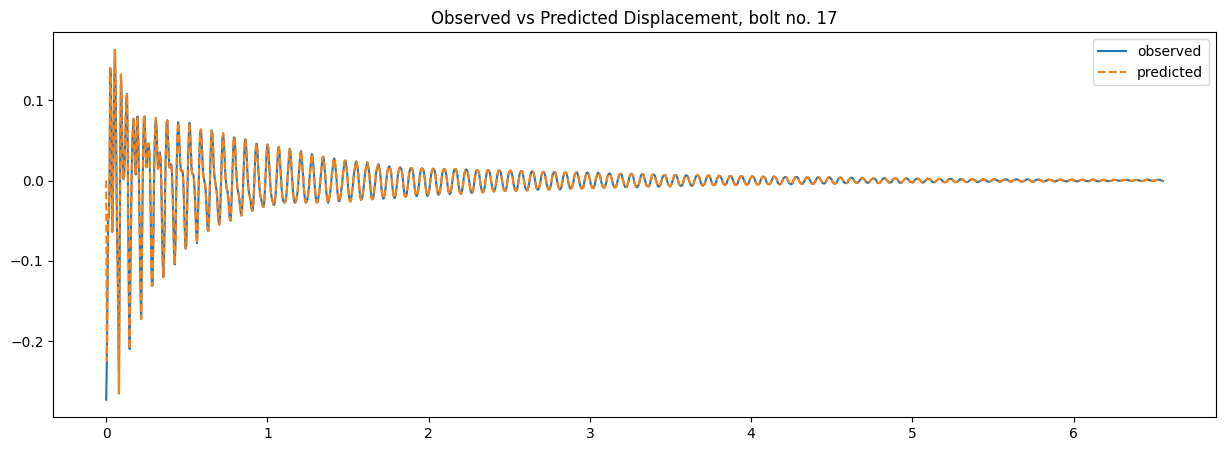

In [190]:
test_series = test_data[0]
Y_pred, _ = predict(W, U, test_series, delay=delay)

print("test series shape", test_series.shape)
print("Y_pred shape", Y_pred.shape)

# setting initial values to zero for plotting
n = test_series.shape[0]
Y_pred = np.hstack([np.zeros((n,1)), Y_pred, np.zeros((n,delay-1))])

print("Y_pred shape after padding", Y_pred.shape)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
t = get_time_from_frames(test_series.shape[1])
randind = random.randint(0, n-1)
ax.plot(t, test_series[randind,:], label='observed')
ax.plot(t, Y_pred[randind,:], label='predicted', linestyle='--')      
ax.legend()
plt.title('Observed vs Predicted Displacement, bolt no. {}'.format(randind+1))
plt.show()
